# Tabular and Fusion models

In [1900]:
import numpy as np
import pandas as pd

In [1901]:
train = pd.read_csv("train_metadata.csv")
test = pd.read_csv("test_metadata.csv")

In [1902]:
y = train["target"]

In [1903]:
train_trim = train.drop("target", axis=1)

Null checking

In [1904]:
nulls = train_trim.apply(lambda col: col.isnull().sum() / col.size * 100)
nulls[nulls > 0]

age_approx             0.694100
sex                    2.875514
anatom_site_general    1.435264
dtype: float64

Filling rows with null age using mean. Sex handled later, anatom_site_general not used.

In [1905]:
train_trim['age_approx'].fillna(train_trim['age_approx'].mean(), inplace=True)

C:\Users\efim6\AppData\Local\Temp\ipykernel_6604\3054032952.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_trim['age_approx'].fillna(train_trim['age_approx'].mean(), inplace=True)


Extract string columns

In [1906]:
string_cols = train_trim.select_dtypes(include="object")
string_cols.columns

Index(['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location',
       'tbp_lv_location_simple'],
      dtype='object')

Check for constant-value columns

In [1907]:
string_cols.apply(lambda row: row.unique())

sex                                                     [male, female, nan]
anatom_site_general       [upper extremity, posterior torso, lower extre...
tbp_tile_type                                           [3D: white, 3D: XP]
tbp_lv_location           [Left Arm - Lower, Torso Back Middle Third, Le...
tbp_lv_location_simple    [Left Arm, Torso Back, Left Leg, Torso Front, ...
dtype: object

Drop ID and other useless string columns

In [1908]:
to_drop = ["tbp_tile_type", "copyright_license", "isic_id", "patient_id", "attribution", "image_type"]
set(string_cols.columns).difference(set(to_drop))

{'anatom_site_general', 'sex', 'tbp_lv_location', 'tbp_lv_location_simple'}

3 location columns, increasing specificity. Using the middle one for one-hot encoding

In [1909]:
string_cols["anatom_site_general"].value_counts()

anatom_site_general
posterior torso    97441
lower extremity    82487
anterior torso     70040
upper extremity    56580
head/neck           9694
Name: count, dtype: int64

In [1910]:
string_cols["tbp_lv_location_simple"].value_counts()

tbp_lv_location_simple
Torso Back     97441
Torso Front    70040
Left Leg       42555
Right Leg      39932
Left Arm       29117
Right Arm      27463
Head & Neck     9694
Unknown         4605
Name: count, dtype: int64

In [1911]:
string_cols["tbp_lv_location"].value_counts()

tbp_lv_location
Torso Back Top Third       56893
Torso Front Top Half       50647
Torso Back Middle Third    36873
Left Leg - Lower           22032
Right Leg - Lower          20124
Torso Front Bottom Half    19351
Left Leg - Upper           18941
Right Arm - Upper          18456
Right Leg - Upper          18451
Left Arm - Upper           18321
Head & Neck                 9694
Left Arm - Lower            9540
Right Arm - Lower           8539
Unknown                     4605
Torso Back Bottom Third     3668
Left Leg                    1582
Right Leg                   1357
Left Arm                    1256
Right Arm                    468
Torso Front                   42
Torso Back                     7
Name: count, dtype: int64

One-hot encoding the sex column. Using a vector of length 2 here to account for the NaaNs - when the value is "unknown", the vector is [0, 0].

In [1912]:
male_indicator = string_cols["sex"].apply(lambda s: float(s == "male" and not s == "unknown"))
male_indicator.name = "Male"
female_indicator = string_cols["sex"].apply(lambda s: float(s == "female" and not s == "unknown"))
female_indicator.name = "Female"

In [1913]:
numerical_sex = pd.concat([male_indicator, female_indicator], axis=1)
numerical_sex.tail()

,Male,Female
320842,0.0,0.0
320843,1.0,0.0
320844,1.0,0.0
320845,1.0,0.0
320846,1.0,0.0


One-hot encoding the location column

In [1914]:
one_hot_location = pd.Series(string_cols["tbp_lv_location_simple"].value_counts().index[:-1]).apply(
    lambda location: string_cols["tbp_lv_location_simple"].apply(lambda loc: float(loc == location))).transpose()
one_hot_location.columns = string_cols["tbp_lv_location_simple"].value_counts().index[:-1]
one_hot_location.head()


tbp_lv_location_simple,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Total one-hot encoded columns

In [1915]:
one_hot_combined = pd.concat([numerical_sex, one_hot_location], axis=1)
one_hot_combined.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalizing other numerical columns to the [0, 1] range with min-max scaling

In [1916]:
numerical = train_trim.select_dtypes(include="number")

for column in numerical.columns: 
    numerical[column] = (numerical[column] - numerical[column].min()) / (numerical[column].max() - numerical[column].min())     

Concat with numerical columns to get the clean data

In [1917]:
clean = pd.concat([one_hot_combined, numerical], axis=1)
clean.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck,id,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,...,0.320724,0.045869,0.102839,0.129462,0.061593,0.192391,0.257143,0.149702,0.776402,0.514450
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,...,0.274954,0.046672,0.088264,0.154240,0.052280,0.259906,0.371429,0.456182,0.714228,0.656138
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000006,...,0.433906,0.118826,0.107364,0.289794,0.048338,0.114581,0.000000,0.323607,0.620132,0.524953
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000009,...,0.165085,0.052959,0.043202,0.142073,0.070101,0.218593,0.514286,0.149161,0.745858,0.452957
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,...,0.417430,0.083788,0.132387,0.074718,0.054687,0.442235,0.000000,0.416389,0.771198,0.311479


Importing the outputs of the image model to be used by the fusion model

In [1918]:
probs = pd.read_csv("vit_train_probabilities_no_leakage.csv")

In [1919]:
clean = pd.concat([clean, probs], axis = 1).drop(columns=["id"])

In [1920]:
y = y[clean.index]

### Distribution Adjustment

In [1921]:
from sklearn.utils.class_weight import compute_class_weight

df = pd.concat([clean, y], axis=1)

print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)
seed = 1

# Distribution definition
T = 0.20
N = 1 - T

neg_count = df.query("target == 0").shape[0]
pos_count = df.query("target == 1").shape[0]

pos_sample = 1.0
neg_sample = (N * pos_count) / (T * neg_count)

positive_df = df.query("target==0").sample(frac=neg_sample, random_state=seed)
negative_df = df.query("target==1").sample(frac=pos_sample, replace=False, random_state=seed)
df = pd.concat([positive_df, negative_df], axis=0)

print("\nClass Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Distribution Before Sampling (%):


target
0    99.902134
1     0.097866
Name: proportion, dtype: float64


Class Distribution After Sampling (%):


target
0    80.0
1    20.0
Name: proportion, dtype: float64

Class Weights: {0: np.float64(0.625), 1: np.float64(2.5)}


## Cross Validation

In [1922]:
from sklearn.model_selection import StratifiedGroupKFold

def get_k_data(df, k):

    # Reset index to ensure a continuous index
    df = df.reset_index(drop=True)
    df["fold"] = -1

    # Set up the StratifiedGroupKFold with 5 splits
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)

    # Assign fold numbers to each data point
    for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.index)):
        df.loc[validation_idx, "fold"] = int(i)
    
    test_fold = k

    training_df = df.query(f"fold != {test_fold}")
    test_df = df.query(f"fold == {test_fold}")

    return training_df, test_df



## Fusion Model

Using the same fold as the image model to prevent data leakage

In [1923]:
train_fold, test_fold = get_k_data(df, 4)
train_fold, test_fold = train_fold.drop("fold", axis=1), test_fold.drop("fold", axis=1)
X_train = train_fold.drop("target", axis=1)
X_test = test_fold.drop("target", axis=1)
y_train = train_fold["target"]
y_test = test_fold["target"]

In [1924]:
import xgboost as xgb

In [1925]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
fusion_booster = xgb.XGBClassifier(seed = seed)
fusion_booster.fit(X_train, y_train)
y_pred = fusion_booster.predict(X_test)
y_test = y_test.to_numpy()

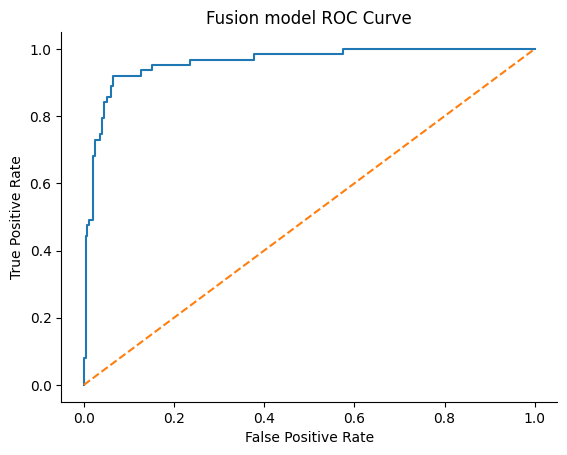

In [1926]:
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
y_probs = fusion_booster.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Fusion model ROC Curve")
plt.plot(np.linspace(0, 1.0, 10000),
         np.linspace(0, 1.0, 10000), linestyle="dashed")
sns.despine()

### Accuracy

In [1927]:
np.mean(y_pred == y_test)

np.float64(0.9299363057324841)

### AUC

In [1928]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.8907860621008031)

### Confusion Matrix

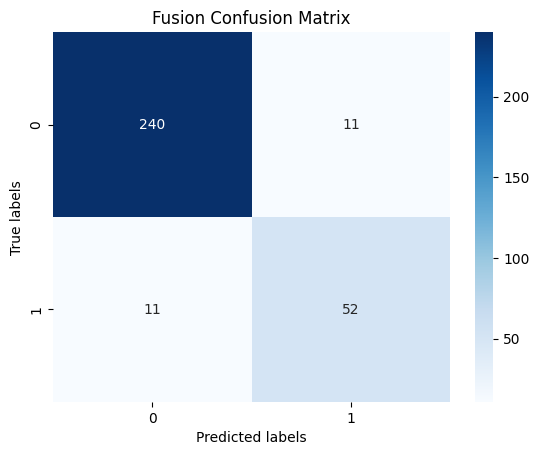

In [1929]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_pred + y_test)
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels[:-1], yticklabels=labels[:-1], cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Fusion Confusion Matrix")
plt.show()

## Tabular Model 

Drop the image model output columns 

In [1930]:
X_train, X_test = X_train.iloc[:, : -2], X_test.iloc[:, : -2]

### Tabular Cross-validation

In [1931]:
from sklearn.metrics import roc_auc_score
accuracies, aucs = [], []
for k in range(5):
    train_fold, test_fold = get_k_data(df, k)
    train_fold, test_fold = train_fold.drop("fold", axis=1), test_fold.drop("fold", axis=1)
    X_train = train_fold.drop("target", axis=1)
    X_test = test_fold.drop("target", axis=1)
    y_train = train_fold["target"]
    y_test = test_fold["target"]
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    tabular_booster = xgb.XGBClassifier(seed = seed)
    tabular_booster.fit(X_train, y_train)
    y_pred = tabular_booster.predict(X_test)
    accuracies.append(np.mean(y_pred == y_test))
    y_probs = tabular_booster.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_pred)
    aucs.append(auc)

for i, acc in enumerate(accuracies):
    print(f"Fold {i + 1} has accuracy {round(acc, 4)}")
    print(f"Fold {i + 1} has AUROC {round(aucs[i], 3)}\n")

Fold 1 has accuracy 0.9013
Fold 1 has AUROC 0.835

Fold 2 has accuracy 0.9172
Fold 2 has AUROC 0.847

Fold 3 has accuracy 0.9268
Fold 3 has AUROC 0.871

Fold 4 has accuracy 0.9363
Fold 4 has AUROC 0.907

Fold 5 has accuracy 0.9299
Fold 5 has AUROC 0.891



### 4th fold had the best performance, used for training

In [1932]:
train_fold, test_fold = get_k_data(df, 3)
train_fold, test_fold = train_fold.drop("fold", axis=1), test_fold.drop("fold", axis=1)
X_train = train_fold.drop("target", axis=1)
X_test = test_fold.drop("target", axis=1)
y_train = train_fold["target"]
y_test = test_fold["target"]


dtrain = xgb.DMatrix(data=X_train, label=y_train)
tabular_booster = xgb.XGBClassifier(seed = seed)
tabular_booster.fit(X_train, y_train)
y_pred = tabular_booster.predict(X_test)

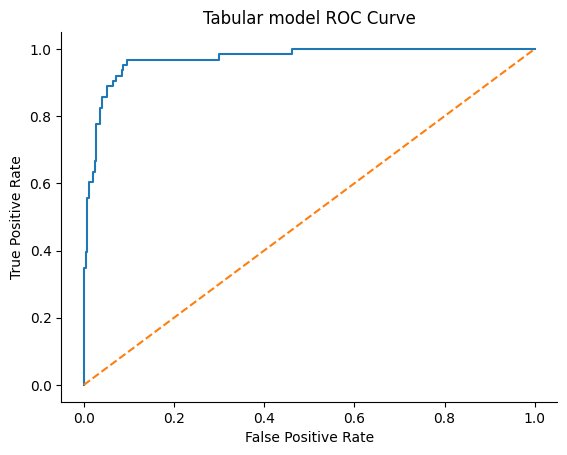

In [1933]:
y_probs = tabular_booster.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Tabular model ROC Curve")
plt.plot(np.linspace(0, 1.0, 10000),
         np.linspace(0, 1.0, 10000), linestyle="dashed")
sns.despine()

### Accuracy

In [1934]:
np.mean(y_pred == y_test)

np.float64(0.9363057324840764)

### AUC

In [1935]:

auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.9066590779738191)

### Confusion Matrix

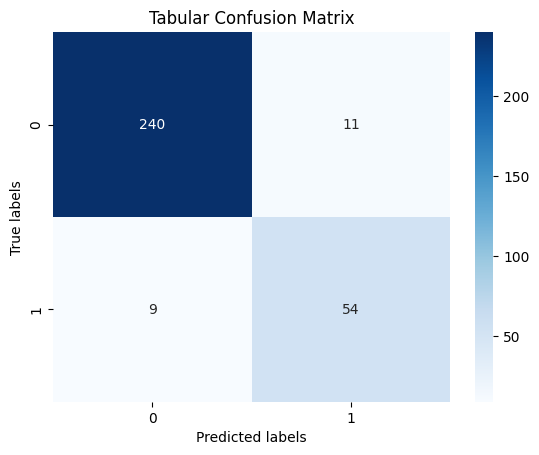

In [1936]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_pred + y_test)
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels[:-1], yticklabels=labels[:-1], cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Tabular Confusion Matrix")
plt.show()

## Competition submission

In [1937]:
def clean_data(train):
    train_trim = train.drop("target", axis=1)
    string_cols = train_trim.select_dtypes(include="object")
    male_indicator = string_cols["sex"].apply(lambda s: float(s == "male" and not s == "unknown"))
    male_indicator.name = "Male"
    female_indicator = string_cols["sex"].apply(lambda s: float(s == "female" and not s == "unknown"))
    female_indicator.name = "Female"
    numerical_sex = pd.concat([male_indicator, female_indicator], axis=1)
    one_hot_location = pd.Series(string_cols["tbp_lv_location_simple"].value_counts().index[:-1]).apply(
    lambda location: string_cols["tbp_lv_location_simple"].apply(lambda loc: float(loc == location))).transpose()
    one_hot_location.columns = string_cols["tbp_lv_location_simple"].value_counts().index[:-1]
    one_hot_combined = pd.concat([numerical_sex, one_hot_location], axis=1)
    numerical = train_trim.select_dtypes(include="number")
    for column in numerical.columns: 
        numerical[column] = (numerical[column] - numerical[column].min()) / (numerical[column].max() - numerical[column].min())     
    clean = pd.concat([one_hot_combined, numerical], axis=1)
    return clean        

### Retrain the model on all of the data (post distribution adjustement)

In [1938]:
submission_booster = xgb.XGBClassifier(seed = seed)
submission_booster.fit(df.drop("target", axis=1), df["target"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Clean test and append image model outputs for the test data

In [1939]:
test = clean_data(test)
test_probs = pd.read_csv("vit_train_probabilities_no_leakage.csv")
index_as_float = test.index.astype(float)
test = pd.concat([test, test_probs], axis = 1).drop(columns=["id"])

In [1940]:
y_pred_submission = submission_booster.predict(test)

pd.Series(y_pred_submission, name="target").astype(float).to_csv("Competition_submission.csv", index=True)

In [1941]:
pd.read_csv("Competition_submission.csv")

,Unnamed: 0,target
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
320842,320842,0.0
320843,320843,0.0
320844,320844,0.0
320845,320845,0.0
